In [2]:
%pip install sentence-transformers


  Using cached sentence_transformers-2.7.0-py3-none-any.whl.metadata (11 kB)
Using cached sentence_transformers-2.7.0-py3-none-any.whl (171 kB)
Note: you may need to restart the kernel to use updated packages.


In [17]:
import json
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, BertConfig
from sentence_transformers import SentenceTransformer
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import tqdm
from sklearn.metrics import accuracy_score


In [2]:
embedding_model = SentenceTransformer('distilbert-base-nli-mean-tokens')



In [21]:
def get_data_lists(data):
    questions = []
    choices = []
    labels = []
    for example in data:
        # print(example.keys())
        questions.append(example['question'])
        choices.append(example['choice_list'])
        labels.append(example['label'])
    return questions, choices, labels

class Brain_Teaser(Dataset):
  def __init__(self, tokenizer, questions, choices, labels, max_len=512):
    self.questions = questions
    self.choices = choices
    self.labels = labels

    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []
    self.question_options_encoded = []

    self.build_questions()
  
  def build_questions(self):
    maxi = 0
    for id in range(len(self.questions)):
      question_options = "Question : " + self.questions[id] + ' ' + "Option: 0" + ' ' + self.choices[id][0] + ' Option: 1 ' + self.choices[id][1] + ' Option: 2 ' + self.choices[id][2] + ' Option: 3 ' + self.choices[id][3]
      self.question_options_encoded.append(self.tokenizer.encode(question_options, convert_to_tensor = True))
    
  def __len__(self):
    return len(self.question_options_encoded)
  
  def __getitem__(self, id):
    return self.question_options_encoded[id],  self.labels[id]
    

class Brain_Teaser_2(Dataset):
  def __init__(self, tokenizer, questions, choices, labels, max_len=512):
    self.questions = questions
    self.choices = choices
    self.labels = labels

    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []
    self.question_options_encoded = []

    self.build_questions()
  
  def build_questions(self):
    maxi = 0
    for id in range(len(self.questions)):
      qo = []
      for option_id in range(4):
        question_options = "Question : " + self.questions[id] + ' ' + "Option: " + str(option_id) + ' ' + self.choices[id][option_id] 
        qo.append(self.tokenizer.encode(question_options, convert_to_tensor = True))
      self.question_options_encoded.append(qo)
    
  def __len__(self):
    return len(self.question_options_encoded)
  
  def __getitem__(self, id):
    return torch.stack(self.question_options_encoded[id]),  self.labels[id]  

In [4]:
data = np.load("data/SP-train.npy", allow_pickle=True)

o_data = []
sr_data = []
cr_data = []

for i in range(len(data)):
    size_ = len(data[i]['id'])

    if data[i]['id'][size_-2:size_] == 'CR':
        cr_data.append(data[i])
    elif data[i]['id'][size_-2:size_] == 'SR':
        sr_data.append(data[i])
    else:
        o_data.append(data[i])

train_data = o_data[:int(len(o_data)*0.8)] + cr_data[:int(len(cr_data)*0.8)] + sr_data[:int(len(sr_data)*0.8)]
val_data = o_data[int(len(o_data)*0.8):int(len(o_data)*0.9)] + cr_data[int(len(cr_data)*0.8):int(len(cr_data)*0.9)] + sr_data[int(len(sr_data)*0.8):int(len(sr_data)*0.9)]
test_data = o_data[int(len(o_data)*0.9):] + cr_data[int(len(cr_data)*0.9):] + sr_data[int(len(sr_data)*0.9):]
# test_data = np.load("data/SP_eval_data_for_practice.npy", allow_pickle = True)

# train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)


train_questions, train_choices, train_labels = get_data_lists(train_data)
val_questions, val_choices, val_labels = get_data_lists(val_data)
test_questions, test_choices, test_labels = get_data_lists(test_data)

In [5]:
train_dataset = Brain_Teaser(embedding_model, train_questions, train_choices, train_labels)
val_dataset = Brain_Teaser(embedding_model, val_questions, val_choices, val_labels)
test_dataset = Brain_Teaser(embedding_model, test_questions, test_choices, test_labels)



In [24]:
test_dataset_2[0]

(tensor([[-0.6462, -0.2440,  0.2941,  ..., -0.0312,  0.3269, -0.2828],
         [-0.4100, -0.1910,  0.3373,  ...,  0.0210,  0.3945, -0.5179],
         [-0.4757, -0.2962,  0.3105,  ...,  0.0132,  0.3523, -0.6067],
         [-0.3288, -0.3289,  0.4456,  ..., -0.0748,  0.2734, -0.7899]],
        device='mps:0'),
 3)

In [22]:
train_dataset_2 = Brain_Teaser_2(embedding_model, train_questions, train_choices, train_labels)
val_dataset_2 = Brain_Teaser_2(embedding_model, val_questions, val_choices, val_labels)
test_dataset_2 = Brain_Teaser_2(embedding_model, test_questions, test_choices, test_labels)


In [7]:
class SentenceModel(nn.Module):
    def __init__(self):
        super(SentenceModel, self).__init__()
        self.fc_1 = nn.Linear(768, 256)
        self.bn_1 = nn.BatchNorm1d(256)  
        self.dropout_1 = nn.Dropout(0.2)  
        self.fc_2 = nn.Linear(256, 32)
        self.bn_2 = nn.BatchNorm1d(32)  
        self.dropout_2 = nn.Dropout(0.3)  
        self.fc_3 = nn.Linear(32, 4)

    def forward(self, x):
        out = self.fc_1(x)
        out = self.bn_1(out)  
        out = nn.functional.relu(out)  
        out = self.dropout_1(out)  
        out = self.fc_2(out)
        out = self.bn_2(out)  
        out = nn.functional.relu(out)  
        out = self.dropout_2(out) 
        out = self.fc_3(out)
        return out

class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.gru_1 = nn.GRU(768, 256, num_layers=1,batch_first=True)
        self.gru_2 = nn.GRU(256, 64, num_layers=1,batch_first=True)
        self.fc_1 = nn.Linear(64, 16)
        self.fc_2 = nn.Linear(16, 4)

    def forward(self, x):
        out, _ = self.gru_1(x)  
        out, _ = self.gru_2(out)              
        out = self.fc_1(out[:, -1, :])
        out = self.fc_2(out)
        return out
    
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn_1 = nn.RNN(768, 256, num_layers=1,batch_first=True)
        self.rnn_2 = nn.RNN(256, 64, num_layers=1,batch_first=True)
        self.fc_1 = nn.Linear(64, 16)
        self.fc_2 = nn.Linear(16, 4)

    def forward(self, x):
        out, _ = self.rnn_1(x)  
        out, _ = self.rnn_2(out)              
        out = self.fc_1(out[:, -1, :])
        # out = nn.functional.relu(out)  
        out = self.fc_2(out)
        return out
    
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm_1 = nn.LSTM(768, 256, num_layers=1,batch_first=True)
        self.lstm_2 = nn.LSTM(256, 64, num_layers=1,batch_first=True)
        self.fc_1 = nn.Linear(64, 16)
        self.fc_2 = nn.Linear(16, 4)

    def forward(self, x):
        out, _ = self.lstm_1(x)  
        out, _ = self.lstm_2(out)              
        out = self.fc_1(out[:, -1, :])
        # out = nn.functional.relu(out)  
        out = self.fc_2(out)
        return out

In [27]:
def train(train_dataset, val_dataset, test_dataset, model, epochs=25, learning_rate=5e-3, batch = 8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=True)
    
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        t_correct = 0
        t_total = 0
        for inputs, targets in tqdm.tqdm(train_dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            _, predicted = torch.max(outputs, 1)
            t_total += targets.size(0)
            t_correct += (predicted == targets).sum().item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        train_loss = running_loss / len(train_dataloader)
        val_loss = val_loss / len(val_dataloader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        test_model(test_dataset, model)
        torch.save(model.state_dict(), 'model'+ str(epoch)+'.pt')

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
                f"Train Accuracy: {(100 * t_correct / t_total):.2f}% , "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {(100 * correct / total):.2f}%")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    

def test_model(test_dataset, model, batch = 8):
    total = 0
    correct = 0
    test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    print(f"Test Accuracy: {(100 * correct / total):.2f}%")




In [ ]:
# model_sentence_fc = SentenceModel()
# train(train_dataset, val_dataset, test_dataset,model_sentence_fc)


100%|██████████| 203/203 [00:01<00:00, 159.29it/s]


Test Accuracy: 23.53%
Epoch [1/30], Train Loss: 1.3191, Train Accuracy: 30.12% , Val Loss: 1.3000, Val Accuracy: 25.49%


100%|██████████| 203/203 [00:00<00:00, 223.69it/s]


Test Accuracy: 19.61%
Epoch [2/30], Train Loss: 1.2368, Train Accuracy: 36.79% , Val Loss: 1.3072, Val Accuracy: 27.45%


100%|██████████| 203/203 [00:00<00:00, 232.05it/s]


Test Accuracy: 27.45%
Epoch [3/30], Train Loss: 1.1937, Train Accuracy: 43.70% , Val Loss: 1.2835, Val Accuracy: 27.45%


100%|██████████| 203/203 [00:00<00:00, 227.13it/s]


Test Accuracy: 21.57%
Epoch [4/30], Train Loss: 1.1527, Train Accuracy: 44.94% , Val Loss: 1.2476, Val Accuracy: 33.33%


100%|██████████| 203/203 [00:00<00:00, 222.86it/s]


Test Accuracy: 17.65%
Epoch [5/30], Train Loss: 1.1105, Train Accuracy: 51.60% , Val Loss: 1.2452, Val Accuracy: 35.29%


100%|██████████| 203/203 [00:00<00:00, 227.12it/s]


Test Accuracy: 19.61%
Epoch [6/30], Train Loss: 1.0684, Train Accuracy: 53.83% , Val Loss: 1.2699, Val Accuracy: 23.53%


100%|██████████| 203/203 [00:00<00:00, 217.88it/s]


Test Accuracy: 19.61%
Epoch [7/30], Train Loss: 1.0397, Train Accuracy: 53.58% , Val Loss: 1.2757, Val Accuracy: 25.49%


100%|██████████| 203/203 [00:00<00:00, 229.71it/s]


Test Accuracy: 27.45%
Epoch [8/30], Train Loss: 0.9973, Train Accuracy: 52.59% , Val Loss: 1.2461, Val Accuracy: 31.37%


100%|██████████| 203/203 [00:01<00:00, 199.75it/s]


Test Accuracy: 23.53%
Epoch [9/30], Train Loss: 0.9633, Train Accuracy: 58.02% , Val Loss: 1.2693, Val Accuracy: 25.49%


100%|██████████| 203/203 [00:00<00:00, 241.64it/s]


Test Accuracy: 25.49%
Epoch [10/30], Train Loss: 0.9254, Train Accuracy: 61.73% , Val Loss: 1.2970, Val Accuracy: 29.41%


100%|██████████| 203/203 [00:00<00:00, 253.28it/s]


Test Accuracy: 23.53%
Epoch [11/30], Train Loss: 0.8973, Train Accuracy: 60.49% , Val Loss: 1.3306, Val Accuracy: 27.45%


100%|██████████| 203/203 [00:00<00:00, 229.49it/s]


Test Accuracy: 23.53%
Epoch [12/30], Train Loss: 0.8512, Train Accuracy: 64.20% , Val Loss: 1.3717, Val Accuracy: 23.53%


100%|██████████| 203/203 [00:00<00:00, 245.81it/s]


Test Accuracy: 25.49%
Epoch [13/30], Train Loss: 0.8175, Train Accuracy: 65.19% , Val Loss: 1.3988, Val Accuracy: 21.57%


100%|██████████| 203/203 [00:00<00:00, 252.16it/s]


Test Accuracy: 25.49%
Epoch [14/30], Train Loss: 0.7898, Train Accuracy: 66.67% , Val Loss: 1.4436, Val Accuracy: 23.53%


100%|██████████| 203/203 [00:00<00:00, 238.86it/s]


Test Accuracy: 27.45%
Epoch [15/30], Train Loss: 0.7592, Train Accuracy: 68.15% , Val Loss: 1.4446, Val Accuracy: 19.61%


100%|██████████| 203/203 [00:00<00:00, 250.98it/s]


Test Accuracy: 25.49%
Epoch [16/30], Train Loss: 0.7280, Train Accuracy: 70.86% , Val Loss: 1.4749, Val Accuracy: 23.53%


100%|██████████| 203/203 [00:00<00:00, 244.70it/s]


Test Accuracy: 29.41%
Epoch [17/30], Train Loss: 0.6806, Train Accuracy: 72.84% , Val Loss: 1.5206, Val Accuracy: 21.57%


100%|██████████| 203/203 [00:00<00:00, 244.33it/s]


Test Accuracy: 29.41%
Epoch [18/30], Train Loss: 0.6530, Train Accuracy: 74.81% , Val Loss: 1.4757, Val Accuracy: 23.53%


100%|██████████| 203/203 [00:00<00:00, 212.88it/s]


Test Accuracy: 21.57%
Epoch [19/30], Train Loss: 0.6267, Train Accuracy: 73.83% , Val Loss: 1.6341, Val Accuracy: 29.41%


100%|██████████| 203/203 [00:00<00:00, 245.40it/s]


Test Accuracy: 27.45%
Epoch [20/30], Train Loss: 0.5987, Train Accuracy: 74.81% , Val Loss: 1.6177, Val Accuracy: 27.45%


100%|██████████| 203/203 [00:00<00:00, 248.73it/s]


Test Accuracy: 25.49%
Epoch [21/30], Train Loss: 0.5615, Train Accuracy: 75.80% , Val Loss: 1.7232, Val Accuracy: 23.53%


100%|██████████| 203/203 [00:00<00:00, 211.94it/s]


Test Accuracy: 25.49%
Epoch [22/30], Train Loss: 0.5266, Train Accuracy: 77.78% , Val Loss: 1.6573, Val Accuracy: 29.41%


100%|██████████| 203/203 [00:00<00:00, 241.60it/s]


Test Accuracy: 27.45%
Epoch [23/30], Train Loss: 0.4987, Train Accuracy: 79.75% , Val Loss: 1.7690, Val Accuracy: 23.53%


100%|██████████| 203/203 [00:00<00:00, 232.67it/s]


Test Accuracy: 23.53%
Epoch [24/30], Train Loss: 0.4658, Train Accuracy: 79.75% , Val Loss: 1.8691, Val Accuracy: 25.49%


100%|██████████| 203/203 [00:01<00:00, 120.58it/s]


Test Accuracy: 23.53%
Epoch [25/30], Train Loss: 0.4462, Train Accuracy: 80.99% , Val Loss: 1.7608, Val Accuracy: 25.49%


100%|██████████| 203/203 [00:01<00:00, 198.04it/s]


Test Accuracy: 29.41%
Epoch [26/30], Train Loss: 0.4221, Train Accuracy: 82.47% , Val Loss: 1.8502, Val Accuracy: 23.53%


100%|██████████| 203/203 [00:00<00:00, 234.06it/s]


Test Accuracy: 27.45%
Epoch [27/30], Train Loss: 0.3897, Train Accuracy: 84.69% , Val Loss: 1.8901, Val Accuracy: 31.37%


100%|██████████| 203/203 [00:00<00:00, 233.53it/s]


Test Accuracy: 25.49%
Epoch [28/30], Train Loss: 0.3697, Train Accuracy: 86.17% , Val Loss: 1.9095, Val Accuracy: 25.49%


100%|██████████| 203/203 [00:00<00:00, 228.67it/s]


Test Accuracy: 25.49%
Epoch [29/30], Train Loss: 0.3481, Train Accuracy: 85.43% , Val Loss: 1.9440, Val Accuracy: 27.45%


100%|██████████| 203/203 [00:01<00:00, 186.41it/s]


Test Accuracy: 25.49%
Epoch [30/30], Train Loss: 0.3374, Train Accuracy: 84.44% , Val Loss: 2.0677, Val Accuracy: 31.37%


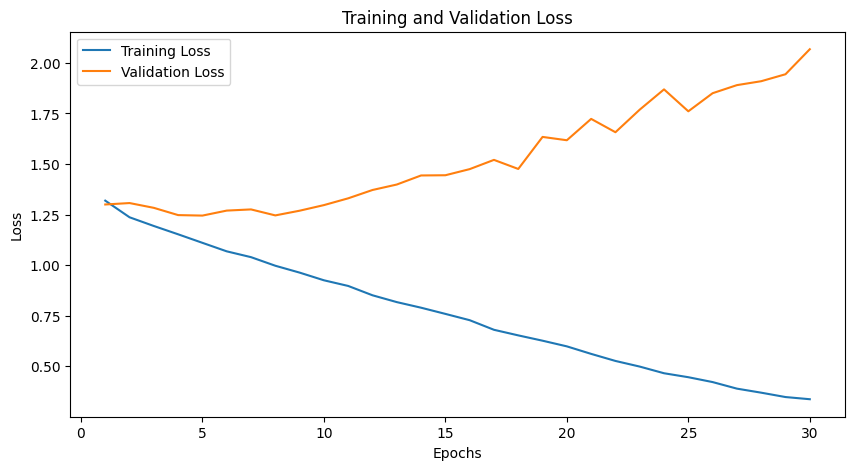

In [20]:
model_sentence_gru = GRUModel()
train(train_dataset_2, val_dataset_2, test_dataset_2, model_sentence_gru, epochs = 30, learning_rate=0.00005, batch=2)

In [23]:
test_model(test_dataset_2, model_sentence_gru)

Test Accuracy: 25.49%


100%|██████████| 102/102 [00:00<00:00, 345.89it/s]


Test Accuracy: 31.37%
Epoch [1/30], Train Loss: 1.2885, Train Accuracy: 33.09% , Val Loss: 1.3038, Val Accuracy: 29.41%


100%|██████████| 102/102 [00:00<00:00, 437.24it/s]


Test Accuracy: 23.53%
Epoch [2/30], Train Loss: 1.1935, Train Accuracy: 42.22% , Val Loss: 1.2574, Val Accuracy: 29.41%


100%|██████████| 102/102 [00:00<00:00, 450.71it/s]


Test Accuracy: 25.49%
Epoch [3/30], Train Loss: 1.1255, Train Accuracy: 45.93% , Val Loss: 1.1862, Val Accuracy: 41.18%


100%|██████████| 102/102 [00:00<00:00, 443.66it/s]


Test Accuracy: 27.45%
Epoch [4/30], Train Loss: 1.0572, Train Accuracy: 57.04% , Val Loss: 1.2029, Val Accuracy: 41.18%


100%|██████████| 102/102 [00:00<00:00, 436.73it/s]


Test Accuracy: 33.33%
Epoch [5/30], Train Loss: 0.9956, Train Accuracy: 57.78% , Val Loss: 1.2146, Val Accuracy: 41.18%


100%|██████████| 102/102 [00:00<00:00, 314.80it/s]


Test Accuracy: 31.37%
Epoch [6/30], Train Loss: 0.9184, Train Accuracy: 63.21% , Val Loss: 1.2499, Val Accuracy: 39.22%


100%|██████████| 102/102 [00:00<00:00, 310.97it/s]


Test Accuracy: 41.18%
Epoch [7/30], Train Loss: 0.8280, Train Accuracy: 72.10% , Val Loss: 1.2050, Val Accuracy: 45.10%


100%|██████████| 102/102 [00:00<00:00, 434.63it/s]


Test Accuracy: 41.18%
Epoch [8/30], Train Loss: 0.7222, Train Accuracy: 73.83% , Val Loss: 1.2188, Val Accuracy: 39.22%


100%|██████████| 102/102 [00:00<00:00, 440.10it/s]


Test Accuracy: 41.18%
Epoch [9/30], Train Loss: 0.6348, Train Accuracy: 79.26% , Val Loss: 1.2238, Val Accuracy: 47.06%


100%|██████████| 102/102 [00:00<00:00, 444.01it/s]


Test Accuracy: 52.94%
Epoch [10/30], Train Loss: 0.5421, Train Accuracy: 86.42% , Val Loss: 1.1896, Val Accuracy: 50.98%


100%|██████████| 102/102 [00:00<00:00, 432.44it/s]


Test Accuracy: 47.06%
Epoch [11/30], Train Loss: 0.4438, Train Accuracy: 89.63% , Val Loss: 1.1878, Val Accuracy: 45.10%


100%|██████████| 102/102 [00:00<00:00, 396.35it/s]


Test Accuracy: 49.02%
Epoch [12/30], Train Loss: 0.3774, Train Accuracy: 90.12% , Val Loss: 1.2027, Val Accuracy: 49.02%


100%|██████████| 102/102 [00:00<00:00, 424.81it/s]


Test Accuracy: 49.02%
Epoch [13/30], Train Loss: 0.3010, Train Accuracy: 93.09% , Val Loss: 1.2165, Val Accuracy: 50.98%


100%|██████████| 102/102 [00:00<00:00, 401.67it/s]


Test Accuracy: 41.18%
Epoch [14/30], Train Loss: 0.2331, Train Accuracy: 96.30% , Val Loss: 1.2310, Val Accuracy: 52.94%


100%|██████████| 102/102 [00:00<00:00, 435.46it/s]


Test Accuracy: 49.02%
Epoch [15/30], Train Loss: 0.1968, Train Accuracy: 95.80% , Val Loss: 1.2789, Val Accuracy: 47.06%


100%|██████████| 102/102 [00:00<00:00, 417.04it/s]


Test Accuracy: 49.02%
Epoch [16/30], Train Loss: 0.1495, Train Accuracy: 98.02% , Val Loss: 1.2263, Val Accuracy: 52.94%


100%|██████████| 102/102 [00:00<00:00, 453.12it/s]


Test Accuracy: 49.02%
Epoch [17/30], Train Loss: 0.1256, Train Accuracy: 98.02% , Val Loss: 1.2873, Val Accuracy: 50.98%


100%|██████████| 102/102 [00:00<00:00, 430.97it/s]


Test Accuracy: 45.10%
Epoch [18/30], Train Loss: 0.0994, Train Accuracy: 98.27% , Val Loss: 1.2699, Val Accuracy: 49.02%


100%|██████████| 102/102 [00:00<00:00, 443.43it/s]


Test Accuracy: 49.02%
Epoch [19/30], Train Loss: 0.0853, Train Accuracy: 98.77% , Val Loss: 1.3893, Val Accuracy: 49.02%


100%|██████████| 102/102 [00:00<00:00, 449.02it/s]


Test Accuracy: 45.10%
Epoch [20/30], Train Loss: 0.0732, Train Accuracy: 98.27% , Val Loss: 1.3851, Val Accuracy: 54.90%


100%|██████████| 102/102 [00:00<00:00, 450.72it/s]


Test Accuracy: 50.98%
Epoch [21/30], Train Loss: 0.0584, Train Accuracy: 99.26% , Val Loss: 1.5099, Val Accuracy: 52.94%


100%|██████████| 102/102 [00:00<00:00, 214.85it/s]


Test Accuracy: 50.98%
Epoch [22/30], Train Loss: 0.0606, Train Accuracy: 99.01% , Val Loss: 1.4464, Val Accuracy: 60.78%


100%|██████████| 102/102 [00:00<00:00, 430.52it/s]


Test Accuracy: 49.02%
Epoch [23/30], Train Loss: 0.0450, Train Accuracy: 99.01% , Val Loss: 1.4096, Val Accuracy: 56.86%


100%|██████████| 102/102 [00:00<00:00, 448.04it/s]


Test Accuracy: 50.98%
Epoch [24/30], Train Loss: 0.0357, Train Accuracy: 99.75% , Val Loss: 1.4266, Val Accuracy: 52.94%


100%|██████████| 102/102 [00:00<00:00, 424.50it/s]


Test Accuracy: 47.06%
Epoch [25/30], Train Loss: 0.0334, Train Accuracy: 99.51% , Val Loss: 1.3559, Val Accuracy: 52.94%


100%|██████████| 102/102 [00:00<00:00, 447.36it/s]


Test Accuracy: 49.02%
Epoch [26/30], Train Loss: 0.0322, Train Accuracy: 99.26% , Val Loss: 1.4024, Val Accuracy: 56.86%


100%|██████████| 102/102 [00:00<00:00, 468.13it/s]


Test Accuracy: 45.10%
Epoch [27/30], Train Loss: 0.0301, Train Accuracy: 99.51% , Val Loss: 1.4354, Val Accuracy: 52.94%


100%|██████████| 102/102 [00:00<00:00, 452.74it/s]


Test Accuracy: 50.98%
Epoch [28/30], Train Loss: 0.0336, Train Accuracy: 99.26% , Val Loss: 1.4436, Val Accuracy: 56.86%


100%|██████████| 102/102 [00:00<00:00, 447.79it/s]


Test Accuracy: 49.02%
Epoch [29/30], Train Loss: 0.0178, Train Accuracy: 99.75% , Val Loss: 1.4625, Val Accuracy: 49.02%


100%|██████████| 102/102 [00:00<00:00, 426.76it/s]


Test Accuracy: 45.10%
Epoch [30/30], Train Loss: 0.0181, Train Accuracy: 99.51% , Val Loss: 1.5644, Val Accuracy: 54.90%


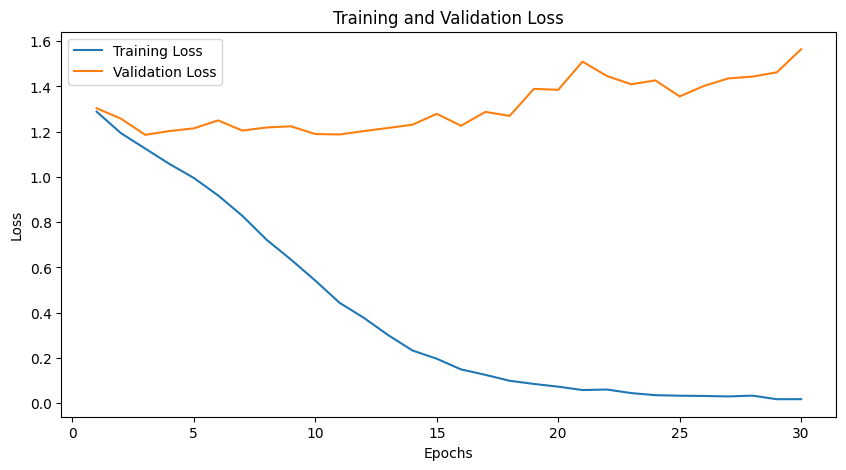

In [29]:
model_sentence_rnn = RNNModel()
train(train_dataset_2, val_dataset_2, test_dataset_2, model_sentence_rnn, epochs = 30, learning_rate=0.0001, batch = 4)

In [20]:
test_model(test_dataset_2, model_sentence_rnn)

Test Accuracy: 47.06%


  0%|          | 0/102 [00:00<?, ?it/s]

100%|██████████| 102/102 [00:00<00:00, 158.54it/s]


Test Accuracy: 23.53%
Epoch [1/30], Train Loss: 1.3239, Train Accuracy: 31.36% , Val Loss: 1.3423, Val Accuracy: 23.53%


100%|██████████| 102/102 [00:00<00:00, 177.42it/s]


Test Accuracy: 23.53%
Epoch [2/30], Train Loss: 1.2635, Train Accuracy: 38.77% , Val Loss: 1.3181, Val Accuracy: 23.53%


100%|██████████| 102/102 [00:00<00:00, 177.39it/s]


Test Accuracy: 23.53%
Epoch [3/30], Train Loss: 1.2140, Train Accuracy: 39.51% , Val Loss: 1.2977, Val Accuracy: 23.53%


100%|██████████| 102/102 [00:00<00:00, 175.25it/s]


Test Accuracy: 21.57%
Epoch [4/30], Train Loss: 1.1691, Train Accuracy: 45.19% , Val Loss: 1.2595, Val Accuracy: 21.57%


100%|██████████| 102/102 [00:00<00:00, 144.85it/s]


Test Accuracy: 19.61%
Epoch [5/30], Train Loss: 1.1219, Train Accuracy: 47.65% , Val Loss: 1.2474, Val Accuracy: 37.25%


100%|██████████| 102/102 [00:00<00:00, 174.01it/s]


Test Accuracy: 17.65%
Epoch [6/30], Train Loss: 1.0733, Train Accuracy: 51.60% , Val Loss: 1.2516, Val Accuracy: 35.29%


100%|██████████| 102/102 [00:00<00:00, 183.54it/s]


Test Accuracy: 21.57%
Epoch [7/30], Train Loss: 1.0182, Train Accuracy: 55.56% , Val Loss: 1.2764, Val Accuracy: 29.41%


100%|██████████| 102/102 [00:00<00:00, 186.69it/s]


Test Accuracy: 23.53%
Epoch [8/30], Train Loss: 0.9677, Train Accuracy: 57.28% , Val Loss: 1.3373, Val Accuracy: 31.37%


100%|██████████| 102/102 [00:00<00:00, 179.20it/s]


Test Accuracy: 29.41%
Epoch [9/30], Train Loss: 0.9200, Train Accuracy: 61.98% , Val Loss: 1.3073, Val Accuracy: 29.41%


100%|██████████| 102/102 [00:00<00:00, 181.62it/s]


Test Accuracy: 25.49%
Epoch [10/30], Train Loss: 0.8679, Train Accuracy: 64.94% , Val Loss: 1.3543, Val Accuracy: 27.45%


100%|██████████| 102/102 [00:00<00:00, 188.39it/s]


Test Accuracy: 27.45%
Epoch [11/30], Train Loss: 0.8162, Train Accuracy: 68.40% , Val Loss: 1.3850, Val Accuracy: 27.45%


100%|██████████| 102/102 [00:00<00:00, 171.46it/s]


Test Accuracy: 35.29%
Epoch [12/30], Train Loss: 0.7705, Train Accuracy: 70.86% , Val Loss: 1.4223, Val Accuracy: 27.45%


100%|██████████| 102/102 [00:00<00:00, 179.56it/s]


Test Accuracy: 27.45%
Epoch [13/30], Train Loss: 0.7207, Train Accuracy: 72.84% , Val Loss: 1.4335, Val Accuracy: 31.37%


100%|██████████| 102/102 [00:00<00:00, 178.94it/s]


Test Accuracy: 33.33%
Epoch [14/30], Train Loss: 0.6722, Train Accuracy: 77.53% , Val Loss: 1.4869, Val Accuracy: 31.37%


100%|██████████| 102/102 [00:00<00:00, 176.71it/s]


Test Accuracy: 29.41%
Epoch [15/30], Train Loss: 0.6255, Train Accuracy: 78.27% , Val Loss: 1.6151, Val Accuracy: 27.45%


100%|██████████| 102/102 [00:00<00:00, 188.78it/s]


Test Accuracy: 33.33%
Epoch [16/30], Train Loss: 0.6031, Train Accuracy: 79.01% , Val Loss: 1.5875, Val Accuracy: 25.49%


100%|██████████| 102/102 [00:00<00:00, 186.97it/s]


Test Accuracy: 29.41%
Epoch [17/30], Train Loss: 0.5631, Train Accuracy: 79.75% , Val Loss: 1.5931, Val Accuracy: 27.45%


100%|██████████| 102/102 [00:00<00:00, 177.28it/s]


Test Accuracy: 37.25%
Epoch [18/30], Train Loss: 0.5165, Train Accuracy: 82.22% , Val Loss: 1.5944, Val Accuracy: 23.53%


100%|██████████| 102/102 [00:00<00:00, 186.55it/s]


Test Accuracy: 33.33%
Epoch [19/30], Train Loss: 0.4740, Train Accuracy: 85.93% , Val Loss: 1.6762, Val Accuracy: 29.41%


100%|██████████| 102/102 [00:00<00:00, 181.03it/s]


Test Accuracy: 33.33%
Epoch [20/30], Train Loss: 0.4492, Train Accuracy: 83.21% , Val Loss: 1.7271, Val Accuracy: 27.45%


100%|██████████| 102/102 [00:00<00:00, 190.83it/s]


Test Accuracy: 33.33%
Epoch [21/30], Train Loss: 0.4131, Train Accuracy: 86.42% , Val Loss: 1.7171, Val Accuracy: 29.41%


100%|██████████| 102/102 [00:00<00:00, 182.40it/s]


Test Accuracy: 33.33%
Epoch [22/30], Train Loss: 0.3859, Train Accuracy: 88.15% , Val Loss: 1.7469, Val Accuracy: 35.29%


100%|██████████| 102/102 [00:00<00:00, 178.46it/s]


Test Accuracy: 31.37%
Epoch [23/30], Train Loss: 0.3694, Train Accuracy: 87.65% , Val Loss: 1.7366, Val Accuracy: 33.33%


100%|██████████| 102/102 [00:00<00:00, 151.37it/s]


Test Accuracy: 35.29%
Epoch [24/30], Train Loss: 0.3400, Train Accuracy: 90.37% , Val Loss: 1.8037, Val Accuracy: 27.45%


100%|██████████| 102/102 [00:00<00:00, 184.68it/s]


Test Accuracy: 33.33%
Epoch [25/30], Train Loss: 0.3374, Train Accuracy: 87.65% , Val Loss: 1.8966, Val Accuracy: 33.33%


100%|██████████| 102/102 [00:00<00:00, 174.35it/s]


Test Accuracy: 31.37%
Epoch [26/30], Train Loss: 0.2850, Train Accuracy: 91.85% , Val Loss: 1.7939, Val Accuracy: 31.37%


100%|██████████| 102/102 [00:00<00:00, 168.48it/s]


Test Accuracy: 31.37%
Epoch [27/30], Train Loss: 0.2831, Train Accuracy: 91.60% , Val Loss: 1.8604, Val Accuracy: 35.29%


100%|██████████| 102/102 [00:00<00:00, 185.17it/s]


Test Accuracy: 35.29%
Epoch [28/30], Train Loss: 0.2793, Train Accuracy: 90.62% , Val Loss: 1.9367, Val Accuracy: 33.33%


100%|██████████| 102/102 [00:00<00:00, 160.08it/s]


Test Accuracy: 33.33%
Epoch [29/30], Train Loss: 0.2399, Train Accuracy: 93.33% , Val Loss: 1.9909, Val Accuracy: 31.37%


100%|██████████| 102/102 [00:00<00:00, 181.25it/s]


Test Accuracy: 29.41%
Epoch [30/30], Train Loss: 0.2176, Train Accuracy: 93.83% , Val Loss: 1.9511, Val Accuracy: 31.37%


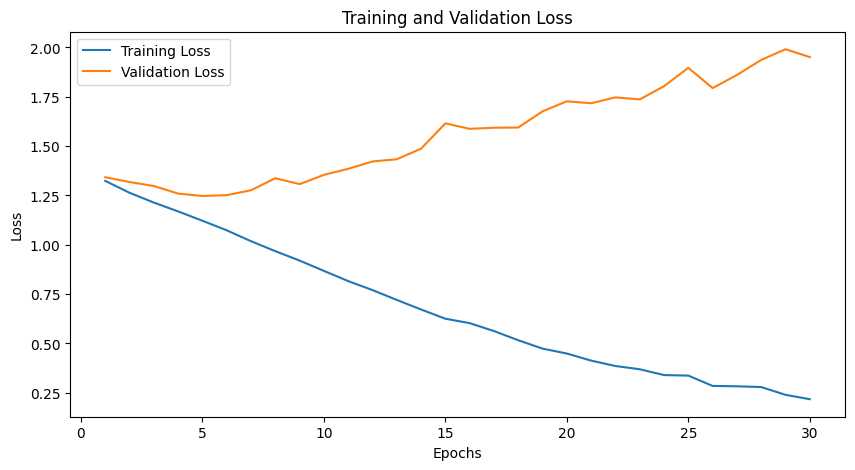

In [18]:
model_sentence_lstm = LSTMModel()
train(train_dataset_2, val_dataset_2, test_dataset_2, model_sentence_lstm, epochs = 30, learning_rate=0.00005, batch = 4)

In [ ]:
test_model(test_dataset, model_sentence_lstm)